In [1]:
import os
import sys
import pandas as pd
import numpy as np
import argparse
import datetime
import time
from sklearn import metrics
from collections import defaultdict
import torch
import torch.nn as nn
from torch import nn, Tensor
from typing import List
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchsummary import summary
from utils.dataset import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# read data
pairs = 1000
pairdata, freqpairs, n_size, n_interval = get_univ_data(pairs)
sizedata = get_data(pairdata, freqpairs, 'size_index', n_size)

In [3]:
seq_set = defaultdict(list)
target_set = defaultdict(list)
size_set = {}
seq_len = 16

for pair in range(pairs):
    size_index = pairdata[freqpairs[pair]].size_index.values
    target_index = np.concatenate((size_index[1:], size_index[0:1]))
    for i in range(len(size_index) - seq_len):
        seq_set[pair].append(size_index[i:i+seq_len])
        target_set[pair].append(target_index[i:i+seq_len])
        size_set[pair] = sizedata[pair]
    seq_set[pair] = np.array(seq_set[pair])
    target_set[pair] = np.array(target_set[pair])

In [4]:
def sample_dataset(seed):
    np.random.seed(seed)
    dataset = []
    for pair in range(pairs):
        ran_index = np.random.randint(len(seq_set[pair]))
        dataset.append([seq_set[pair][ran_index], size_set[pair], target_set[pair][ran_index]])
    return dataset

def inputTensor(lines):
    tensor = torch.zeros(lines.shape[1], lines.shape[0], n_size, dtype=torch.long)
    for line in range(lines.shape[0]):
        for i in range(lines.shape[1]):
            size = lines[line][i]
            tensor[i][line][size] = 1
    return tensor

dataset = sample_dataset(0)
dataloader = DataLoader(dataset[:32], batch_size=32, shuffle=False)

In [5]:
class SizeToHidden(nn.Module):
    def __init__(self, input_size, hidden_dims, hidden_size, n_layer):
        super(SizeToHidden, self).__init__()
        self.lins = nn.ModuleList()
        self.n_layer = n_layer
        self.hidden_size = hidden_size
        in_dim = input_size 
        for h_dim in hidden_dims:
            self.lins.append(
                nn.Sequential(
                    nn.Linear(in_dim, out_features=h_dim),
                    nn.ReLU())
            )
            in_dim = h_dim
        self.output = nn.Linear(in_dim, out_features=hidden_size * n_layer)

    def forward(self, x: Tensor) -> List[Tensor]:
        for lin in self.lins:
            x = lin(x)
        x = self.output(x)
        x = x.view(-1, self.n_layer, self.hidden_size)
        x = x.permute(1, 0, 2).contiguous()
        return x

In [6]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, n_layer):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, n_layer)
        self.h2o = nn.Linear(hidden_size, n_size)
        self.softmax = nn.LogSoftmax(dim=2)
    
    def forward(self, x, hidden):
        out, hidden = self.gru(x, hidden)
        out = self.h2o(out)
        out = self.softmax(out)
        return out, hidden

In [7]:
hidden_size = 256
gru = GRU(n_size, hidden_size, 1).to(device)
s2h = SizeToHidden(n_size, [64, 128], hidden_size, 1).to(device)

In [16]:
# hidden_size = 128
# gru = GRU(n_size, hidden_size, 1).to(device)
# s2h = SizeToHidden(n_size, [64, 128], hidden_size, 1).to(device)

In [17]:
# get total parameters and trainable parameters of gru and s2h
def get_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params
get_params(gru)[0], get_params(s2h)[0], get_params(gru)[0] + get_params(s2h)[0]

(228894, 43328, 272222)

In [18]:
sum_flow = 0
for i in range(pairs):
    sum_flow += len(pairdata[freqpairs[i]])
sum_flow

287915

In [19]:
(get_params(gru)[0] + get_params(s2h)[0]) / 900000

0.3024688888888889

In [20]:
# date = 'final'
# gru = torch.load('model/{date}/gru.pth'.format(date=date))
# s2h = torch.load('model/{date}/s2h.pth'.format(date=date))

In [11]:
date = 'univ-gru-2023-6-16-23'
gru = torch.load('model/{date}/gru-82000.pth'.format(date=date))
s2h = torch.load('model/{date}/s2h-82000.pth'.format(date=date))

In [12]:
def train(dataloader, optimizer):
    gru.train()
    s2h.train()
    sum_loss = 0
    for seq_tensor, size_tensor, target_tensor in dataloader:
        seq_tensor = inputTensor(seq_tensor).float().to(device)
        size_tensor = size_tensor.float().to(device)
        target_tensor = target_tensor.T.long().to(device)
        optimizer.zero_grad()
        output, hn = gru(seq_tensor, s2h(size_tensor))
        loss = 0
        for i in range(seq_len):
            loss += nn.NLLLoss()(output[i], target_tensor[i])
        loss.backward()
        optimizer.step()
        sum_loss += loss.item() / seq_tensor.shape[0] * seq_tensor.shape[1]
    return sum_loss / len(dataloader.dataset)

In [10]:
lr = 5e-4
optimizer = torch.optim.Adam([{'params': gru.parameters()}, {'params': s2h.parameters()}], lr=lr)

s_time = time.time()
plot_every = 1000
avg_loss = 0
for i in range(1000001):
    dataset = sample_dataset(i)
    dataloader = DataLoader(dataset[:], batch_size=32, shuffle=True)
    loss = train(dataloader, optimizer)
    avg_loss += loss
    if i and i % plot_every == 0:
        print(i, loss, avg_loss / plot_every, time.time() - s_time)
        if avg_loss / plot_every < 0.18:
            print(i, avg_loss / plot_every)
            break
        avg_loss = 0

KeyboardInterrupt: 

In [13]:
softmax = nn.Softmax(dim=2).to(device)
def sample(size_data, seq_length, start_size=8):
    gru.eval()
    s2h.eval()
    with torch.no_grad():  # no need to track history in sampling
        size_tensor = torch.tensor(size_data, dtype=torch.float).to(device)
        hn = s2h(size_tensor)
        output_seq = [start_size]
        size = start_size
        for _ in range(seq_length - 1):
            input = inputTensor(np.array([[size]])).to(device)
            input = input.float()
            output, hn = gru(input, hn)
            output = softmax(output)
            p_size = output.detach().cpu().numpy().squeeze()
            size = np.random.choice(n_size, p=p_size)
            output_seq.append(size)
        return output_seq

def is_subarray(arr1, arr2):
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    for i in range(len(arr1) - len(arr2) + 1):
        if np.array_equal(arr1[i:i+len(arr2)], arr2):
            return True
    return False

In [14]:
# pair = 0
# start_size = 8
# for i in range(100):
#     size_index = np.concatenate((pairdata[freqpairs[pair]].size_index.values, pairdata[freqpairs[pair]].size_index.values[0:1]))
#     a = sample(sizedata[pair], 16, start_size)
#     print(a, is_subarray(size_index, a))

In [15]:
from scipy.stats import entropy
def JSD(p, q):
    p = list(p)
    q = list(q)
    pq_max_len = max(len(p), len(q))
    p += [0.0] * (pq_max_len - len(p))
    q += [0.0] * (pq_max_len - len(q))
    assert (len(p) == len(q))
    m = np.sum([p, q], axis=0) / 2
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

s2s_pair, size_trans = get_trans(pairdata, freqpairs, 'size_index', n_size)

In [16]:
from tqdm import tqdm
encore_seq = np.zeros((pairs, 1000))
he_seq = np.zeros((pairs, 1000))

for pair in tqdm(range(1000)):
    size_data = sizedata[pair]
    size_index = np.concatenate((pairdata[freqpairs[pair]].size_index.values, pairdata[freqpairs[pair]].size_index.values[0:1]))

    size_seq = []
    while len(size_seq) < 1000:
        size = np.random.choice(np.arange(n_size), p=sizedata[pair])
        size_seq.append(size)
    size_seq = np.array(size_seq)[0:1000]
    he_seq[pair] = size_seq

    for seed in range(100):
        np.random.seed(seed)
        torch.manual_seed(seed)
        start_size = np.random.choice(np.arange(n_size), p=sizedata[pair])
        size_seq = [start_size]
        while len(size_seq) < 1000:
            new_size = sample(size_data, 16, start_size=start_size)
            if set(new_size).issubset(np.unique(pairdata[freqpairs[pair]].size_index.values)):
                size_seq += list(new_size[1:])
                start_size = new_size[-1]
                if seed > 10:
                    start_size = np.random.choice(np.arange(30), p=sizedata[pair])
        
        size_seq = np.array(size_seq)
        values, counts = np.unique(size_seq, return_counts=True)
        new_size = np.zeros(n_size, dtype=float)
        new_size[values] = counts
        new_size /= new_size.sum()

        rnn_s2s_pair = [size_seq[:-1] * n_size + size_seq[1:]]  
        values, counts = np.unique(rnn_s2s_pair, return_counts=True)
        rnn_s2s_pair = np.zeros(n_size ** 2, dtype=float)
        rnn_s2s_pair[values] = counts
        rnn_s2s_pair /= rnn_s2s_pair.sum()
        
        if JSD(new_size, sizedata[pair]) < 0.05:
            break
        print(pair, seed, JSD(new_size, sizedata[pair]), JSD(rnn_s2s_pair, s2s_pair[pair]))
    encore_seq[pair] = size_seq[0:1000]

  0%|          | 2/1000 [00:00<04:13,  3.94it/s]

2 0 0.056853017340285604 0.11849388086610652
2 1 0.07297684221754352 0.13383879068738208
2 2 0.0664212272928147 0.12134937438495239
2 3 0.0527226307539924 0.10005102795466926
2 4 0.06698011543247671 0.12134910143383
2 5 0.07017870106803697 0.12599409072158743
2 6 0.07034070838399373 0.1232157491385647
2 7 0.06814080515051318 0.14561842879489428
2 8 0.06232254049277042 0.1251787503280667
2 9 0.06326147551732662 0.11361839199880158
2 10 0.06272585303207653 0.11176606195621017


  1%|          | 9/1000 [00:04<05:46,  2.86it/s]

9 0 0.05587981167984434 0.1092260731821178


  1%|          | 11/1000 [00:05<05:47,  2.84it/s]

11 0 0.10336890420453382 0.16421612542542274
11 1 0.13547780372676488 0.2257997157410564
11 2 0.1164649358683712 0.1965744834058313
11 3 0.06967240982958921 0.1048088552737255
11 4 0.06721885717782822 0.1047203185646966
11 5 0.12639998701715466 0.21114960915345432
11 6 0.058706325759368794 0.08676684245028347
11 7 0.07649513822896173 0.11588908390328642
11 8 0.06788574736028477 0.09855678614802557
11 9 0.1219094322651503 0.20233608497453565
11 10 0.09564689496681467 0.14936616426554156


  2%|▏         | 20/1000 [00:10<04:48,  3.40it/s]

20 0 0.07348925139595286 0.16669207415497223
20 1 0.0654369083908414 0.1741200213947711
20 2 0.0576183777187546 0.16446613046942418
20 3 0.0712604200468086 0.16456786165942733


  3%|▎         | 32/1000 [00:14<04:01,  4.01it/s]

32 0 0.05660714707148146 0.13479182862586553


  4%|▎         | 35/1000 [00:15<04:28,  3.59it/s]

35 0 0.12474149317614927 0.13375530176833383
35 1 0.18983104887192626 0.20140870833091093
35 2 0.22903334206215492 0.24270859553008634
35 3 0.2142871774550606 0.22815147823456614
35 4 0.14882070534914774 0.15807798707970633
35 5 0.19122071322597464 0.2050831035712253
35 6 0.18580131570491704 0.1974591330304622
35 7 0.22903334206215492 0.24270859553008634
35 8 0.14558368701983998 0.15604133183351682
35 9 0.22903334206215492 0.24270859553008634
35 10 0.22568742785014892 0.24080694165894434


  8%|▊         | 76/1000 [00:28<03:50,  4.02it/s]

76 0 0.0808516409295132 0.15864575268425862


 10%|▉         | 95/1000 [00:33<03:56,  3.83it/s]

95 0 0.05071552964309932 0.05453176315846671
95 1 0.05017755329133249 0.053326722707853456


 16%|█▌        | 162/1000 [00:50<03:38,  3.84it/s]

162 0 0.13337637552265866 0.14036373914726757
162 1 0.12571396676308103 0.14004218650989447
162 2 0.13385695655868723 0.13918378089520764
162 3 0.13668983725884667 0.1399636026559761
162 4 0.1124912911248147 0.13037923717019112
162 5 0.11677373427830548 0.12321215961971384
162 6 0.12743218148047256 0.13806564949908534
162 7 0.1246203644765245 0.1292798981588263
162 8 0.13124629427523965 0.13776029879218557
162 9 0.1157060695950414 0.11970671612670895
162 10 0.1339070051868936 0.13989033072510132


 16%|█▋        | 165/1000 [00:54<09:03,  1.54it/s]

165 0 0.14213516853019842 0.1495149304628221
165 1 0.14359414991320182 0.15518316447992553
165 2 0.14566328595082062 0.156694442148953
165 3 0.14049465322514515 0.14616025851807266
165 4 0.13961565478911664 0.15047418524395556
165 5 0.12961383361709305 0.13847546368573008
165 6 0.14494894311127707 0.15524408714933763
165 7 0.10891845446810348 0.11869936937906805
165 8 0.1494599853894706 0.16437978542386938
165 9 0.14359414991320182 0.15495155394129848
165 10 0.14213516853019842 0.1495149304628221


 18%|█▊        | 185/1000 [01:01<03:23,  4.00it/s]

185 0 0.0977486882214889 0.14741268060335086
185 1 0.11789514650043836 0.17585283801100068
185 2 0.14872075182536781 0.20178286141214657
185 3 0.19098226704204202 0.24355399826253632
185 4 0.14097924587616162 0.18559991286257865
185 5 0.17572739858202996 0.23309155902214818
185 6 0.1830855569874311 0.23280761423032426
185 7 0.2095267775587999 0.2599111328372222
185 8 0.1604671917936332 0.2108512188074444
185 9 0.20455200193812292 0.26060404366002465
185 10 0.17648958437270412 0.22881553446584935


 20%|█▉        | 199/1000 [01:08<03:28,  3.85it/s]

199 0 0.06346295066907535 0.0886134901727588


 21%|██        | 212/1000 [01:11<03:20,  3.92it/s]

212 0 0.06096430413533811 0.0935293660367333
212 1 0.0547765677469898 0.08496132376752046
212 2 0.07477028869099739 0.11272975680668298


 24%|██▍       | 239/1000 [01:19<03:12,  3.96it/s]

239 0 0.09989183139821392 0.12182561466760188
239 1 0.08598810821943796 0.10949679290683706
239 2 0.08943373565517607 0.11127290596004352
239 3 0.12736477543207797 0.14862391205640962
239 4 0.09532215230268494 0.11713554518168334
239 5 0.10569817112329982 0.13019733052104887
239 6 0.0841689896526295 0.10697490098826856
239 7 0.0847231419730986 0.10394376240560084
239 8 0.06405051266250081 0.08489949797770391
239 9 0.12860485761521567 0.1526099704017701
239 10 0.08303184621995766 0.10488801469768683


 29%|██▊       | 286/1000 [01:33<02:58,  4.00it/s]

286 0 0.10912909481105305 0.11730715950286026
286 1 0.07673260192035783 0.0841912333299768


 31%|███       | 312/1000 [01:40<02:52,  3.98it/s]

312 0 0.06161460942162895 0.07784750852329193


 32%|███▏      | 318/1000 [01:42<02:59,  3.80it/s]

318 0 0.054590032911936016 0.09308388073879942
318 1 0.053957008013842796 0.09394762235395868


 34%|███▍      | 338/1000 [01:47<02:47,  3.95it/s]

338 0 0.07008726519153263 0.08589306078200692
338 1 0.05836420953434666 0.07361120557177113
338 2 0.0771006573399155 0.09081882277572845
338 3 0.09506265185049474 0.1080984882565029
338 4 0.06169428315574888 0.0757971463753162


 34%|███▍      | 345/1000 [01:50<03:12,  3.40it/s]

345 0 0.06934212047015693 0.07334091802679167
345 1 0.09118710377006496 0.09443461406468617
345 2 0.07783373785340969 0.08177902237252921
345 3 0.121126744579592 0.12668200930161422


 37%|███▋      | 366/1000 [01:57<02:37,  4.03it/s]

366 0 0.09881082235445711 0.17323678793888944


 39%|███▉      | 389/1000 [02:03<02:33,  3.97it/s]

389 0 0.14842502509770006 0.22354448007289127
389 1 0.14623941763924975 0.23320565324402767
389 2 0.09762498322205995 0.14491257357540538
389 3 0.05720293608024775 0.09149950340965018


 47%|████▋     | 469/1000 [02:24<02:16,  3.90it/s]

469 0 0.05167239975916377 0.09994408416897838
469 1 0.059862762891217156 0.11245128211662338
469 2 0.05418040235715238 0.11698720552240956
469 3 0.05034819981592561 0.10397738075816543
469 4 0.06513217031310624 0.122008364924033
469 5 0.061836014599234074 0.11244199369376248


 49%|████▉     | 491/1000 [02:31<02:10,  3.91it/s]

491 0 0.07943497538379503 0.09152522573726703
491 1 0.1091072308397456 0.12594848403224362
491 2 0.11785556141211886 0.12870645815787587
491 3 0.06351629274629744 0.07983678131420183
491 4 0.06597960491726365 0.09371365512828678
491 5 0.12192762488440365 0.13031871489471714


 51%|█████     | 510/1000 [02:37<02:05,  3.90it/s]

510 0 0.08521355523927221 0.0976191359359117


 53%|█████▎    | 534/1000 [02:44<01:57,  3.95it/s]

534 0 0.05340431340704337 0.0725465161153172
534 1 0.06444050044311435 0.08981499939580163
534 2 0.06740471370094134 0.08622972916985336
534 3 0.06305377599471852 0.08826834353625468
534 4 0.05151493039042679 0.07459487132392237


 63%|██████▎   | 627/1000 [03:08<01:35,  3.90it/s]

627 0 0.05045277860228296 0.07525777073995515
627 1 0.05559934811007649 0.07978115953256747


 76%|███████▌  | 762/1000 [03:43<01:00,  3.96it/s]

762 0 0.05856532539671575 0.11795912735822017


 83%|████████▎ | 827/1000 [04:00<00:43,  3.98it/s]

827 0 0.053166043850750314 0.09682342407832051


 93%|█████████▎| 930/1000 [04:26<00:18,  3.87it/s]

930 0 0.11007371945455692 0.17201326392110544
930 1 0.054120192671364684 0.12508397538224686


 98%|█████████▊| 985/1000 [04:41<00:03,  3.94it/s]

985 0 0.06859012354616743 0.16274843488652674


100%|██████████| 1000/1000 [04:45<00:00,  3.51it/s]


In [17]:
grams = {}
for i in [2, 3, 4]:
    grams[i] = np.zeros((pairs, n_size ** i))
    for pair in tqdm(range(pairs)):
        sizeindex = pairdata[freqpairs[pair]]['size_index'].values
        l = len(sizeindex) - i + 1
        feature = np.zeros(l, dtype=int)
        for j in range(i):
            feature += sizeindex[j:j+l] * n_size ** (i - j - 1)
        values, counts = np.unique(feature, return_counts=True)
        grams[i][pair][values] = counts
    grams[i] /= grams[i].sum(axis=1).reshape(-1, 1)

he_grams = {}
for i in [2, 3, 4]:
    he_grams[i] = np.zeros((pairs, n_size ** i))
    for pair in tqdm(range(pairs)):
        sizeindex = he_seq[pair].astype(int)
        l = len(sizeindex) - i + 1
        feature = np.zeros(l, dtype=int)
        for j in range(i):
            feature += sizeindex[j:j+l] * n_size ** (i - j - 1)
        values, counts = np.unique(feature, return_counts=True)
        he_grams[i][pair][values] = counts
    he_grams[i] /= he_grams[i].sum(axis=1).reshape(-1, 1)

encore_grams = {}
for i in [2, 3, 4]:
    encore_grams[i] = np.zeros((pairs, n_size ** i))
    for pair in tqdm(range(pairs)):
        sizeindex = encore_seq[pair].astype(int)
        l = len(sizeindex) - i + 1
        feature = np.zeros(l, dtype=int)
        for j in range(i):
            feature += sizeindex[j:j+l] * n_size ** (i - j - 1)
        values, counts = np.unique(feature, return_counts=True)
        encore_grams[i][pair][values] = counts
    encore_grams[i] /= encore_grams[i].sum(axis=1).reshape(-1, 1)

100%|██████████| 1000/1000 [00:00<00:00, 13201.92it/s]


In [18]:
def JSD(p, q):
    p = list(p)
    q = list(q)
    pq_max_len = max(len(p), len(q))
    p += [0.0] * (pq_max_len - len(p))
    q += [0.0] * (pq_max_len - len(q))
    assert (len(p) == len(q))
    m = np.sum([p, q], axis=0) / 2
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

In [19]:
he_jsds, encore_jsds = {}, {}
for i in range(2, 5):
    he_jsds[i] = []    
    encore_jsds[i] = []    
    for pair in tqdm(range(pairs)):
        he_jsds[i].append(JSD(grams[i][pair], he_grams[i][pair]))
        encore_jsds[i].append(JSD(grams[i][pair], encore_grams[i][pair]))
    he_jsds[i] = np.array(he_jsds[i])
    encore_jsds[i] = np.array(encore_jsds[i])

100%|██████████| 1000/1000 [06:22<00:00,  2.61it/s]


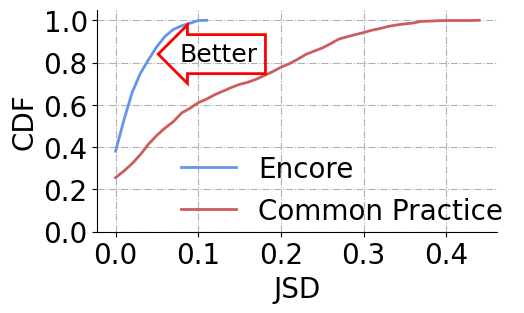

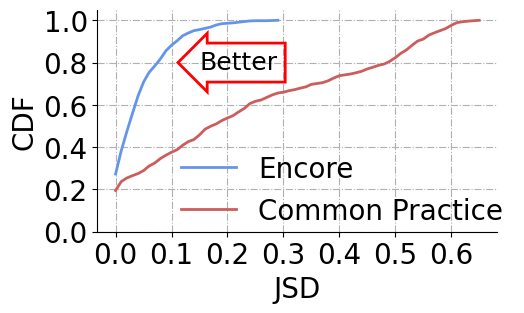

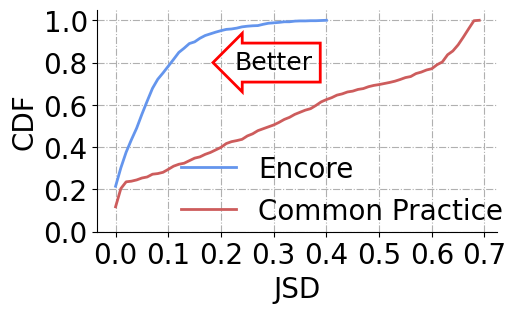

In [21]:
import matplotlib.pyplot as plt

for i in range(2, 5):
    plt.figure(figsize=(5, 3))
    plt.subplots_adjust(left=0.18, top=0.98, bottom=0.24, right=0.98)
    ax = plt.subplot(111)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    values, bins = np.histogram(encore_jsds[i], bins=np.arange(0, np.max(encore_jsds[i]) + 0.01, 0.01))
    cdf = np.cumsum(values) / np.sum(values)
    plt.plot(bins[:-1], cdf, linewidth=2, color='CornFlowerBlue', label='Encore')
    values, bins = np.histogram(he_jsds[i], bins=np.arange(0, np.max(he_jsds[i]) + 0.01, 0.01))
    cdf = np.cumsum(values) / np.sum(values)
    plt.plot(bins[:-1], cdf, linewidth=2, color='IndianRed', label='Common Practice')
    plt.ylim(0, 1.05)
    plt.legend(fontsize=20, frameon=False)
    plt.ylabel('CDF', fontsize=20)
    plt.xlabel('JSD', fontsize=20)
    plt.grid(linestyle='-.')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    if i == 2:
        bbox_props = dict(boxstyle="larrow", fc="none", ec="red", lw=2)
        t = ax.text(0.125, 0.84, "Better", ha="center", va="center", rotation=0,
                    size=18,
                    bbox=bbox_props)
    elif i == 3:
        bbox_props = dict(boxstyle="larrow", fc="none", ec="red", lw=2)
        t = ax.text(0.22, 0.8, "Better", ha="center", va="center", rotation=0,
                    size=18,
                    bbox=bbox_props)
    else:
        bbox_props = dict(boxstyle="larrow", fc="none", ec="red", lw=2)
        t = ax.text(0.3, 0.8, "Better", ha="center", va="center", rotation=0,
                    size=18,
                    bbox=bbox_props)
    plt.legend(fontsize=20, frameon=False, loc=(0.18, -0.02))

    plt.savefig('figure/{i}-gram-jsd.pdf'.format(i=i), dpi=300)

In [65]:
rnn_jsds, he_jsds = [], []
for pair in range(1000):
    size_data = sizedata[pair]
    size_index = np.concatenate((pairdata[freqpairs[pair]].size_index.values, pairdata[freqpairs[pair]].size_index.values[0:1]))

    for seed in range(100):
        np.random.seed(seed)
        torch.manual_seed(seed)
        start_size = np.random.choice(np.arange(30), p=sizedata[pair])
        size_seq_gen = [start_size]
        while len(size_seq_gen) < 1000:
            new_size = sample(size_data, 16, start_size=start_size)
            if set(new_size).issubset(np.unique(pairdata[freqpairs[pair]].size_index.values)):
                size_seq_gen += list(new_size[1:])
                start_size = new_size[-1]
                if seed > 10:
                    start_size = np.random.choice(np.arange(30), p=sizedata[pair])
        size_seq_gen = np.array(size_seq_gen)
        values, counts = np.unique(size_seq_gen, return_counts=True)
        new_size = np.zeros(n_size, dtype=float)
        new_size[values] = counts
        new_size /= new_size.sum()

        rnn_s2s_pair = [size_seq_gen[:-1] * n_size + size_seq_gen[1:]]  
        values, counts = np.unique(rnn_s2s_pair, return_counts=True)
        rnn_s2s_pair = np.zeros(n_size ** 2, dtype=float)
        rnn_s2s_pair[values] = counts
        rnn_s2s_pair /= rnn_s2s_pair.sum()
        
        # print(seed, JSD(new_size, sizedata[pair]), JSD(rnn_s2s_pair, s2s_pair[pair]))
        if JSD(new_size, sizedata[pair]) < 0.05:
            break

    rnn_s2s_pair = [size_seq_gen[:-1] * n_size + size_seq_gen[1:]]  
    values, counts = np.unique(rnn_s2s_pair, return_counts=True)
    rnn_s2s_pair = np.zeros(n_size ** 2, dtype=float)
    rnn_s2s_pair[values] = counts
    rnn_s2s_pair /= rnn_s2s_pair.sum()

    he_size_seq = []
    while len(he_size_seq) < 1000:
        size = np.random.choice(np.arange(30), p=sizedata[pair])
        he_size_seq.append(size)
    he_size_seq = np.array(he_size_seq)

    he_s2s_pair = [he_size_seq[:-1] * n_size + he_size_seq[1:]]  
    values, counts = np.unique(he_s2s_pair, return_counts=True)
    he_s2s_pair = np.zeros(n_size * n_size, dtype=float)
    he_s2s_pair[values] = counts
    he_s2s_pair /= he_s2s_pair.sum()

    print(pair, JSD(new_size, sizedata[pair]), JSD(rnn_s2s_pair, s2s_pair[pair]), JSD(he_s2s_pair, s2s_pair[pair]))
    rnn_jsds.append(JSD(rnn_s2s_pair, s2s_pair[pair]))
    he_jsds.append(JSD(he_s2s_pair, s2s_pair[pair]))

0 0.00013337454857514745 0.0006931725411965916 0.026807747731062814
1 0.011805364549085675 0.06839816184360163 0.2333550043571106
2 0.048848161873076834 0.12050960591118719 0.3377306129364187


KeyboardInterrupt: 

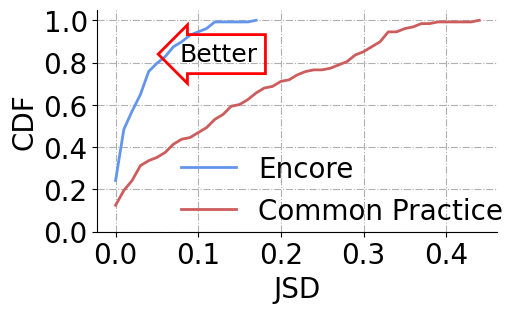

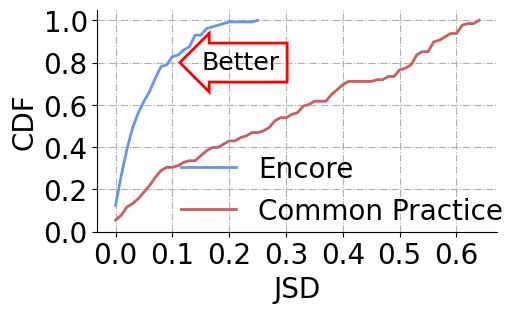

In [41]:
for i in [50, 90, 95, 99]:
    print(i, np.percentile(rnn_jsds, i), np.percentile(he_jsds, i))

50 0.016796066997483282 0.07346432855368562
90 0.07909204873483928 0.2751986895385197
95 0.09532450370252392 0.31491465589104833
99 0.1320168295307611 0.3700949495105308


In [136]:
for i in [50, 90, 95, 99]:
    print(i, np.percentile(rnn_jsds, i), np.percentile(he_jsds, i))

50 0.012160265192768834 0.07145898533012404
90 0.047915725836543216 0.2727736298325866
95 0.053717750535610495 0.3153216864822403
99 0.06597230544940674 0.36794891171362076


In [10]:
# torch.save(gru, 'models/gru-0504.pth')
# torch.save(s2h, 'models/s2h-0504.pth')

In [11]:
class SizeDecoder(torch.nn.Module):
    def __init__(self, output_dim, hidden_dims, latent_dim):
        super(SizeDecoder, self).__init__()
        self.decoder = torch.nn.ModuleList()
        in_dim = latent_dim
        for h_dim in hidden_dims:
            self.decoder.append(
                nn.Sequential(
                    nn.Linear(in_dim, out_features=h_dim,),
                    nn.ReLU())
            )
            in_dim = h_dim
        self.output = nn.Linear(hidden_dims[-1], output_dim)
    
    def forward(self, x: Tensor) -> List[Tensor]:
        for module in self.decoder:
            x = module(x)
        result = self.output(x)
        result = F.softmax(result, dim=1)
        return result
    
decoder = torch.load('models/size-decoder-0425.pth')
gru = torch.load('models/gru-0504.pth')
s2h = torch.load('models/s2h-0504.pth')

In [50]:
from scipy.stats import entropy
from tqdm import tqdm
def JSD(p, q):
    p = list(p)
    q = list(q)
    pq_max_len = max(len(p), len(q))
    p += [0.0] * (pq_max_len - len(p))
    q += [0.0] * (pq_max_len - len(q))
    assert (len(p) == len(q))
    m = np.sum([p, q], axis=0) / 2
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

def sample_noisy_dataset(n, seed):
    torch.manual_seed(seed)
    dataset = []
    for i in tqdm(range(n)):
        latent_dim = 32
        z = torch.randn((1, latent_dim)).to(device)
        size = decoder(z)
        size = size.squeeze().detach().to('cpu').numpy()
        size[size < 1e-3] = 0
        size /= size.sum()

        dis = []
        for j in range(1000):
            loss = JSD(size, sizedata[j])
            dis.append(loss)

        pair = np.argmin(dis)
        ran_index = np.random.randint(len(seq_set[pair]))
        dataset.append([seq_set[pair][ran_index], size, target_set[pair][ran_index]])
        
    return dataset

In [71]:
a = []
for i in tqdm(range(1000)):
    torch.manual_seed(i)
    latent_dim = 32
    z = torch.randn((1, latent_dim)).to(device)
    size = decoder(z)
    size = size.squeeze().detach().to('cpu').numpy()
    size[size < 1e-3] = 0
    size /= size.sum()

    dis = []
    for j in range(1000):
        loss = JSD(size, sizedata[j])
        dis.append(loss)

    pair = np.argmin(dis)
    a.append(pair)

100%|██████████| 5000/5000 [05:13<00:00, 15.93it/s]


In [47]:
lr = 1e-3
# optimizer = torch.optim.Adam([{'params': s2h.parameters()}], lr=lr)
optimizer = torch.optim.Adam([{'params': gru.parameters()}, {'params': s2h.parameters()}], lr=lr)

s_time = time.time()
plot_every = 100
avg_loss = 0
for i in range(1000001):
    dataset = sample_dataset(i)
    ran_index = np.random.permutation(len(tune_dataset))[0:1000]
    # dataset.extend([tune_dataset[i] for i in ran_index])
    dataloader = DataLoader(dataset, batch_size=2000, shuffle=True)
    loss = train(dataloader, optimizer)
    avg_loss += loss
    if i and i % plot_every == 0:
        print(i, loss, avg_loss / plot_every, time.time() - s_time)
        if avg_loss / plot_every < 0.1:
            print(i, avg_loss / plot_every)
            break
        avg_loss = 0

100 0.37469881772994995 0.36950908958911893 11.19027829170227
200 0.36915746331214905 0.35975850641727447 21.188878059387207
300 0.35969191789627075 0.35673402369022367 32.09577918052673


KeyboardInterrupt: 

In [74]:
from tqdm import tqdm
a = set()
for i in tqdm(range(1000)):
    torch.manual_seed(i)
    latent_dim = 32
    z = torch.randn((1, latent_dim)).to(device)
    size = decoder(z)
    size = size.squeeze().detach().to('cpu').numpy()
    size[size < 1e-3] = 0
    size /= size.sum()

    dis = []
    for j in range(1000):
        loss = JSD(size, sizedata[j])
        dis.append(loss)
        # if loss < 0.02:
        #     a.add(j)

    pair = np.argmin(dis)
    a.add(pair)

100%|██████████| 1000/1000 [00:58<00:00, 17.09it/s]


In [73]:
jsds = np.zeros((1000, 1000))
for i in range(1000):
    for j in range(1000):
        jsds[i][j] = JSD(sizedata[i], sizedata[j])

In [75]:
np.sort(jsds[8])

array([0.        , 0.0712686 , 0.0989841 , 0.10461984, 0.10732551,
       0.11061315, 0.11413909, 0.11538036, 0.11660952, 0.11782312,
       0.12270552, 0.12357579, 0.12381709, 0.12831985, 0.12900488,
       0.13021052, 0.13290488, 0.13328528, 0.13464494, 0.13588953,
       0.13698097, 0.13924533, 0.14027519, 0.14082266, 0.14095486,
       0.14102039, 0.14222849, 0.14290341, 0.14387662, 0.14660579,
       0.14678407, 0.14694698, 0.14717077, 0.14719107, 0.14890525,
       0.14939437, 0.14958512, 0.15188435, 0.1524103 , 0.15251156,
       0.15369764, 0.1559504 , 0.15639397, 0.15688702, 0.15898742,
       0.15899087, 0.16149691, 0.16396171, 0.16474164, 0.16477304,
       0.1657369 , 0.16581361, 0.16621777, 0.16631866, 0.1666306 ,
       0.16702055, 0.16783559, 0.16789516, 0.16937711, 0.16999767,
       0.17006917, 0.17089419, 0.17237322, 0.17269899, 0.17295262,
       0.17311279, 0.1738042 , 0.17434601, 0.17441435, 0.17492409,
       0.17498089, 0.17590966, 0.17673751, 0.1767769 , 0.17685

In [65]:
(jsds < 0.01).sum(axis=1)

array([  2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   3,   1,   1,  95,   1,   1,   1,   1,   1,   2,   1,  96,
         1,   1,   1,   4,   1,   2,   1,   1,   1,   1,   2,   1,   3,
         1,   1,   1,   2,   3,   1,   1,   2,   4,   2,   1,   1,   1,
         2,   1,   2,   1,   1,   1,   1,   1,   1,   1,   4,   3,   1,
         3,   1,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   3,
         1,   1,   6,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   3,   1,   1,   1,   1,   1,   1,   6,
         2,   1,   1,   4,   1,   2,   1,   1,   1,   1,   1,   1,   4,
         1,   1,   1,   1,   1,   1,   1,  76,   2,   1,   1,  29,   1,
         1,   4,   5,   1,   1,   1,   1,   1,   2,   1,   1,   5,   7,
         4,   1,   2,   1,   5,   1,   4,   1,   1,   1,   1,  20,   7,
         5,   1,   1,   1,   1,   1,   1,   1,   5,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   4,   2,   1,   1,   1,   1,   